In [18]:
# Test datası genel data yolunda yoksa bu kodu çalıştırın. 
# Bir model için bir kez çalışsa yeter diğer modellerde çalıştırmayın.
# Test_Batch 1500 ise doğrudur. Üstü veya altı olmamalıdır.
# Assert yapmadan ilerlemeyin.
'''
import os 
import glob
import shutil
import random
os.chdir('/Users/batu/Desktop/DeepLearningProject/data/happy-vs-angry') 
if  os.path.isdir('test/angry') is False:
    os.makedirs('test/angry')
    os.makedirs('test/happy')  

for i in random.sample(glob.glob('train/angry/*'), 750):
    shutil.move(i, 'test/angry')
for i in random.sample(glob.glob('train/happy/*'), 750):
    shutil.move(i, 'test/happy')
'''

In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

from sklearn.model_selection import train_test_split

train_dir = '/Users/batu/Desktop/DeepLearningProject/data/happy-vs-angry/train'
validation_dir = '/Users/batu/Desktop/DeepLearningProject/data/happy-vs-angry/validation'
test_dir = '/Users/batu/Desktop/DeepLearningProject/data/happy-vs-angry/test'

IMAGE_SIZE = (48, 48)  
BATCH_SIZE = 10 
COLOR_MODE = 'grayscale'
train_set = ImageDataGenerator(rescale=1./255)
test_set = ImageDataGenerator(rescale=1./255)
valid_set = ImageDataGenerator(rescale=1./255)


train_batch = train_set.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    color_mode=COLOR_MODE,
    classes=['angry', 'happy'],
)

valid_batch = valid_set.flow_from_directory(
    validation_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    color_mode=COLOR_MODE,
    classes=['angry', 'happy'],
)

test_batch = test_set.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    color_mode=COLOR_MODE,
    classes=['angry', 'happy'],
    shuffle=False
)


Found 9657 images belonging to 2 classes.
Found 2785 images belonging to 2 classes.
Found 1500 images belonging to 2 classes.


In [5]:
assert train_batch.n == 9657
assert valid_batch.n == 2785
assert test_batch.n == 1500
assert train_batch.num_classes == valid_batch.num_classes == test_batch.num_classes == 2 

In [7]:
imgs, labels = next(train_batch)
print(imgs.shape)

(10, 48, 48, 1)


In [8]:
import matplotlib.pyplot as plt

def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

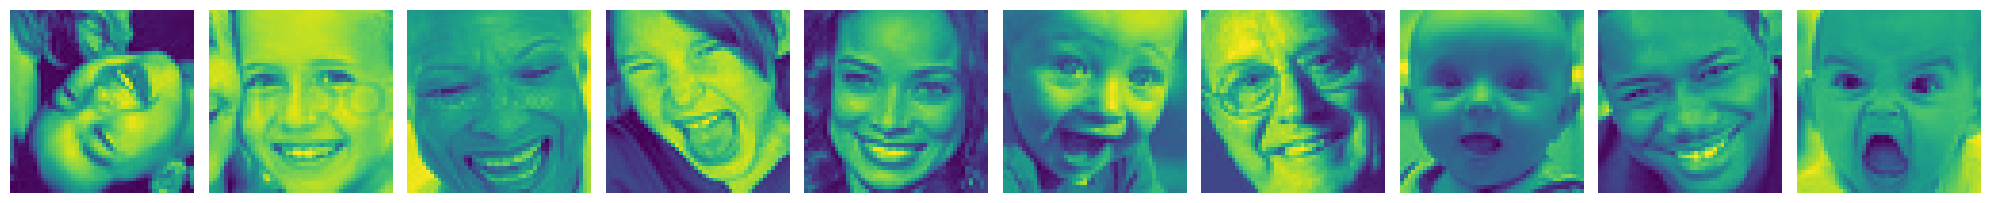

[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]]


In [9]:
plotImages(imgs)
print(labels)

In [11]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.optimizers import Adam

model = Sequential()

# 1st CNN layer
model.add(Conv2D(64, (3, 3), padding='same', input_shape=(48, 48, 1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


# 2nd CNN layer
model.add(Conv2D(128, (5, 5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


# 3rd CNN layer
model.add(Conv2D(512, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


# 4th CNN layer
model.add(Conv2D(512, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())

# Fully connected 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))


# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))


model.add(Dense(units= 2, activation='sigmoid'))

opt = Adam(learning_rate=0.0001)  
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

In [13]:
history = model.fit(train_batch, validation_data=valid_batch, epochs=50, verbose=2)

Epoch 1/50


2024-05-12 10:28:39.692472: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


KeyboardInterrupt: 

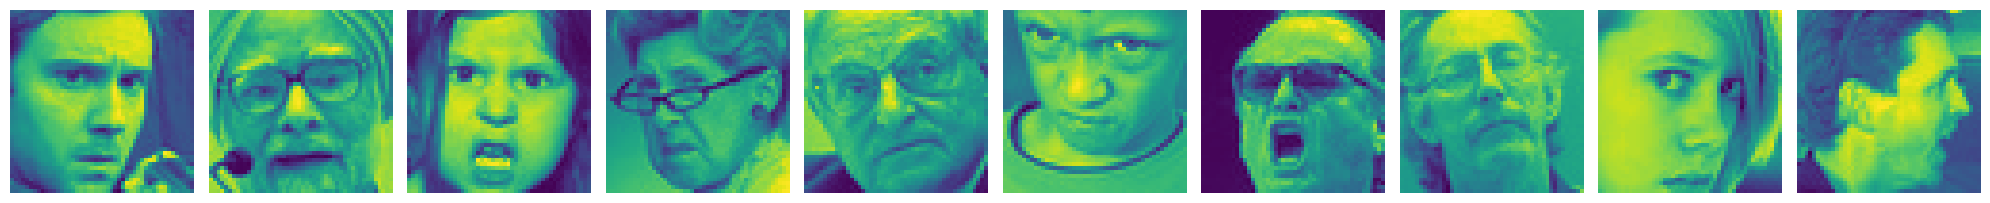

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [14]:
test_imgs, labels = next(test_batch)
plotImages(test_imgs)
print(labels)
# No shuffle in test batch so it will be in order

In [15]:
imgs.shape

(10, 48, 48, 1)

In [17]:
test_batch.classes
test_batch.class_indices

{'angry': 0, 'happy': 1}

In [ ]:
predictions = model.predict(x=test_batch, verbose=0)

In [ ]:
rounded_predictions = np.round(predictions)
print(rounded_predictions)
rounded_predictions = np.argmax(rounded_predictions, axis=-1)

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true=test_batch.classes, y_pred=rounded_predictions) # Note the classes are in order                

In [ ]:
import itertools
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
classes = ['angry', 'happy']
plot_confusion_matrix(cm=cm, classes=classes, title='Confusion Matrix')  

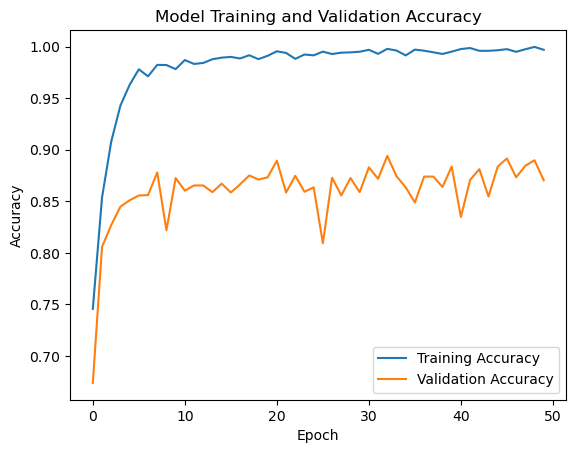

In [8]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
import os 
# Save the model to disk if not already saved

model_path = 'Path/to/your/model.h5'
if not os.path.exists(model_path):
    model.save(model_path)
    print("Added model to disk")
else:
    print("!")